In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

pre_trained = "bert-base-german-cased"

### Hyperparameters


In [2]:
epochs = 40
batch_size = 1
drop_out = 0.2

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  

In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [6]:

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.5324055358846258
Validation loss: 1.522657168277884
F1 Score (Weighted): 0.6175968285380098


Epoch 2:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.316621501842974
Validation loss: 1.486920722661693
F1 Score (Weighted): 0.6961089994118881


Epoch 3:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.0601934366107575
Validation loss: 1.7642614806965906
F1 Score (Weighted): 0.7201735722341531


Epoch 4:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.8187093647150844
Validation loss: 1.7315548807353238
F1 Score (Weighted): 0.748484947247368


Epoch 5:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.6011915400205841
Validation loss: 2.0731906046354167
F1 Score (Weighted): 0.730856168848543


Epoch 6:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.5194516723661808
Validation loss: 2.409206568928357
F1 Score (Weighted): 0.7196930198815047


Epoch 7:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.40694732801147016
Validation loss: 2.2282006149311884
F1 Score (Weighted): 0.7130132211969559


Epoch 8:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.3964449403718325
Validation loss: 2.4503452118168156
F1 Score (Weighted): 0.7191858261464824


Epoch 9:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.3039075188198943
Validation loss: 2.5424647106923137
F1 Score (Weighted): 0.7069309616406799


Epoch 10:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.2835403561869161
Validation loss: 2.622712049048555
F1 Score (Weighted): 0.7151215839926154


Epoch 11:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.25153779845712193
Validation loss: 2.6761867539958755
F1 Score (Weighted): 0.7032716452479121


Epoch 12:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.20614313796495828
Validation loss: 2.530058145898145
F1 Score (Weighted): 0.7211913146562194


Epoch 13:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.19229236682279335
Validation loss: 2.3431154936286736
F1 Score (Weighted): 0.7218550621314527


Epoch 14:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.1702459102423204
Validation loss: 2.596527270248389
F1 Score (Weighted): 0.731690340876096


Epoch 15:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.13092598418783566
Validation loss: 2.550791639264932
F1 Score (Weighted): 0.7557305536450805


Epoch 16:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.14343500316787253
Validation loss: 2.609685577054344
F1 Score (Weighted): 0.7343458897222368


Epoch 17:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.12369601191901956
Validation loss: 2.727463746564728
F1 Score (Weighted): 0.744824226347807


Epoch 18:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.1207114485942796
Validation loss: 2.70375042700898
F1 Score (Weighted): 0.7397688954533116


Epoch 19:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.12211223314469825
Validation loss: 2.75996921047052
F1 Score (Weighted): 0.7288218706018306


Epoch 20:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.09573977412798895
Validation loss: 2.7038105990716166
F1 Score (Weighted): 0.7363790415470681


Epoch 21:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.07131324145062377
Validation loss: 3.0702529016972595
F1 Score (Weighted): 0.7109681183211826


Epoch 22:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.09980182094578881
Validation loss: 2.7558101219422833
F1 Score (Weighted): 0.7113070377720123


Epoch 23:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.07271849164733897
Validation loss: 2.797035578682084
F1 Score (Weighted): 0.7202386928760536


Epoch 24:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.07243817119673047
Validation loss: 2.9856878489659
F1 Score (Weighted): 0.7073402584115036


Epoch 25:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.08231222951194254
Validation loss: 2.9757481106830284
F1 Score (Weighted): 0.736414926274188


Epoch 26:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.06785943359314102
Validation loss: 2.8535460591940693
F1 Score (Weighted): 0.7259160527814801


Epoch 27:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.06201391667073022
Validation loss: 2.8198720920608396
F1 Score (Weighted): 0.7275640559637788


Epoch 28:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.08012770906608788
Validation loss: 2.9220621747847453
F1 Score (Weighted): 0.7149425334521964


Epoch 29:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.06423725738370206
Validation loss: 2.8824737638840587
F1 Score (Weighted): 0.7270763896106022


Epoch 30:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.06480280339549956
Validation loss: 2.8558888045183406
F1 Score (Weighted): 0.7396009612396385


Epoch 31:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 31
Training loss: 0.06964124543345708
Validation loss: 2.8897613754551825
F1 Score (Weighted): 0.7295159456284831


Epoch 32:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 32
Training loss: 0.05720744132650118
Validation loss: 2.852883605367846
F1 Score (Weighted): 0.7298150935601309


Epoch 33:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 33
Training loss: 0.056610405197269016
Validation loss: 3.0554188702717937
F1 Score (Weighted): 0.7140826986930602


Epoch 34:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 34
Training loss: 0.06084541495931728
Validation loss: 2.9908788659234897
F1 Score (Weighted): 0.7191536105477088


Epoch 35:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 35
Training loss: 0.04683486912299437
Validation loss: 3.0129810317032932
F1 Score (Weighted): 0.7207758667902473


Epoch 36:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 36
Training loss: 0.0447637990913213
Validation loss: 3.008537498888862
F1 Score (Weighted): 0.7209563726424081


Epoch 37:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 37
Training loss: 0.05755669538004713
Validation loss: 3.027984670513083
F1 Score (Weighted): 0.7279254776892999


Epoch 38:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 38
Training loss: 0.051154681150665196
Validation loss: 3.0614170273376384
F1 Score (Weighted): 0.7203578521391001


Epoch 39:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 39
Training loss: 0.04361854965979643
Validation loss: 3.0577908032520145
F1 Score (Weighted): 0.7206060659984787


Epoch 40:   0%|          | 0/2046 [00:00<?, ?it/s]


Epoch 40
Training loss: 0.04392076782592743
Validation loss: 3.0741129084728605
F1 Score (Weighted): 0.7178137719951009


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((accuracy, i+1))
print(total_acc)

[(1, 0.6175968285380098), (2, 0.6961089994118881), (3, 0.7201735722341531), (4, 0.748484947247368), (5, 0.730856168848543), (6, 0.7196930198815047), (7, 0.7130132211969559), (8, 0.7191858261464824), (9, 0.7069309616406799), (10, 0.7151215839926154), (11, 0.7032716452479121), (12, 0.7211913146562194), (13, 0.7218550621314527), (14, 0.731690340876096), (15, 0.7557305536450805), (16, 0.7343458897222368), (17, 0.744824226347807), (18, 0.7397688954533116), (19, 0.7288218706018306), (20, 0.7363790415470681), (21, 0.7109681183211826), (22, 0.7113070377720123), (23, 0.7202386928760536), (24, 0.7073402584115036), (25, 0.736414926274188), (26, 0.7259160527814801), (27, 0.7275640559637788), (28, 0.7149425334521964), (29, 0.7270763896106022), (30, 0.7396009612396385), (31, 0.7295159456284831), (32, 0.7298150935601309), (33, 0.7140826986930602), (34, 0.7191536105477088), (35, 0.7207758667902473), (36, 0.7209563726424081), (37, 0.7279254776892999), (38, 0.7203578521391001), (39, 0.7206060659984787),

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

[(0.5928739466941823, 1), (0.6646000391922002, 2), (0.6820983043427568, 3), (0.7065471207588607, 4), (0.6936626241120788, 5), (0.6825975004209925, 6), (0.6773625049659651, 7), (0.687126230989567, 8), (0.6672538744643087, 9), (0.6825069470051951, 10), (0.6703099260860647, 11), (0.6820019106229037, 12), (0.6844322032599995, 13), (0.7007084968541565, 14), (0.7208649070625995, 15), (0.6970486957386716, 16), (0.71026491815657, 17), (0.7030723468842739, 18), (0.6890150815731878, 19), (0.697368539295003, 20), (0.678176422384457, 21), (0.6790937194856563, 22), (0.6871667415807563, 23), (0.6739649167725396, 24), (0.7004469411835764, 25), (0.6873712652047753, 26), (0.6913560320926675, 27), (0.67904046799306, 28), (0.6909511347630617, 29), (0.7008349878888879, 30), (0.6933347468785725, 31), (0.6911575573549916, 32), (0.6786049796809576, 33), (0.6844550403903532, 34), (0.6837047579514675, 35), (0.6827069752463677, 36), (0.6913560320926675, 37), (0.6848905287024557, 38), (0.6848905287024557, 39), (

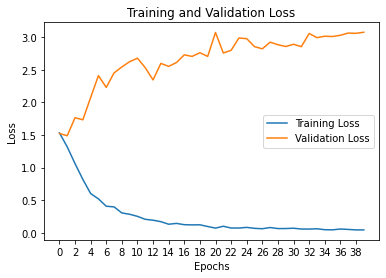

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()